# Classification And Regression Tree -- CART:

### Author: Yifan Wang

##### Useful resources: 

* http://www.stat.wisc.edu/~loh/treeprogs/guide/wires11.pdf

* ftp://ftp.boulder.ibm.com/software/analytics/spss/support/Stats/Docs/Statistics/Algorithms/14.0/TREE-CART.pdf

* https://en.wikipedia.org/wiki/Decision_tree_learning

* https://www.quora.com/What-are-the-splitting-criteria-for-a-regression-tree#

Some significant different of CART from other algorithm, ID3 specifically (since we've implemented that)

* Use gini index instead of information gain to select split for classification

* Use max MSE reduction to select split for regression

* perform pruning after building the tree (we will not be doing it here, since the reason we build CART is targeting at the gradient boosting next steps)


#### Here we will implement both Classification and Regression Trees:

### Classification Tree:

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from collections import Counter

In [6]:
class CART_classfier():
    'Implementation of CART(Classification and Regression Tree) Decision Tree in Python, majorly in NumPy'
    def __init__(self,least_children_num,verbose=True):
        self.least_children_num = least_children_num
        self.verbose = verbose
        
    
    def fit(self,tmp_x,tmp_y):
        def fit_tree(tmp_x,tmp_y):
        #     Exit Condition 0:
            # Exit Condition 1:
            if \
            len(tmp_y) < self.least_children_num or len(np.unique(tmp_y))==1:

                if self.verbose:
                    print('exit condition:')
                    print('tmp_y:')
                    print(tmp_y)

                mode_val = self.mode(tmp_y.flatten().tolist())
                return([np.nan, mode_val, np.nan, np.nan]) # Leaf Node: format [feat,splitval,]

            # Otherwise Split:
            if self.verbose:
                print("start....subset Y len {}".format(len(tmp_y)))


            split_row,split_col = self.decide_split_data(tmp_x,tmp_y)

            if not split_row and not split_col:
                print('no better split...return mode')
                mode_val = self.mode(tmp_y.flatten().tolist())
                return([np.nan, mode_val, np.nan, np.nan])

            if self.verbose:
                print("split on:")
                print(split_row,split_col)


            split_vec = tmp_x[:,split_col]
            split_val = tmp_x[split_row,split_col]

            # Recursively Split to left and right branches:
            left_ind = np.where(split_vec<split_val)[0].tolist()
            right_ind = np.where(split_vec>=split_val)[0].tolist()
            left_dat,left_y = tmp_x[left_ind,:],tmp_y[left_ind,]
            right_dat,right_y = tmp_x[right_ind,:],tmp_y[right_ind,]

            left_tree = fit_tree(left_dat,left_y)
            right_tree = fit_tree(right_dat,right_y)

            if isinstance(left_tree, list): # If list, tree len 1
                len_l_tree = 1
            else:
                len_l_tree = left_tree.shape[0] # If array, tree len >1

            root = [split_col,split_val,1,len_l_tree+1] # Format [split_col, split_val, left_tree_relative_idx, right_tree_relative_idx]
            return(np.vstack([root,left_tree,right_tree]))
        
        tree = fit_tree(tmp_x,tmp_y)
        self.tree = tree

    

    def decide_split_data(self,x,y):
        'Given subset of X,Y, search for the best splitting node based on: gini index'
        def gini_index(tmp_y):
            'Key Metrics of building a decision tree. Specifically Gini Index'
            tmp_ent = 1
            for uni_y in np.unique(tmp_y):
                p = len(tmp_y[tmp_y==uni_y])/len(tmp_y)
                tmp_ent -= p**2
            return tmp_ent

        m,n = x.shape
        best_gain = 0
        split_row, split_col = None,None

        previous_gini = gini_index(y)
        for col in range(n):
            tmp_vec = x[:,col].ravel()

            for row in range(m):
                val = tmp_vec[row]
                # >= & < is my convention here:
                if val!=np.max(tmp_vec) and val!= np.min(tmp_vec):
                    left_b = np.where(tmp_vec<val)[0].tolist()
                    right_b = np.where(tmp_vec>=val)[0].tolist()

                    new_gini = \
                    (len(y[left_b])/len(y))*gini_index(y[left_b]) + \
                    (len(y[right_b])/len(y))*gini_index(y[right_b])


    #                 print('new entropy: %f'%new_ent)
                    gini_gain = previous_gini - new_gini

                    if gini_gain > best_gain:
                        split_row, split_col = row,col
                        best_gain = gini_gain
                        if self.verbose:
                            print('better gain:{}'.format(best_gain))
                            print()

        return split_row, split_col
                
                

    def mode(self, x_list):
        'calculate the mode'
        return Counter(x_list).most_common(1)[0][0]

    
    

    
    
    

    
    
    
    def predict(self, tmp_test_array):
        'Wrap-up fun for prediction'
        def query(tree,tmp_test_array):
            'Test for single example'
            assert len(tmp_test_array.shape) == 2, "Make sure your test data is 2d array"
        #     print(tree)

            if isinstance(tree,list):
                start_node = tree # only the 1 row in data
            else:
                start_node = tree[0,:] # Iteratively hit first row
        #     print(start_node)
        #     print()
            test_feat,test_val,left_tree_jump,right_tree_jump = start_node[0],start_node[1],start_node[2],start_node[3]

            # Exit Condition:
            if np.isnan(test_feat) and np.isnan(left_tree_jump) and np.isnan(right_tree_jump):
                pred = test_val;
                return pred 
            #Test:
            if tmp_test_array[0,int(test_feat)] < test_val:
                # If <, go left branch:
                jump_loc = left_tree_jump
                pred = query(tree[int(jump_loc):,],tmp_test_array)

            else:
                # If >=, go right branch:
                jump_loc = right_tree_jump
                pred = query(tree[int(jump_loc):,],tmp_test_array)

            return pred

        assert len(tmp_test_array.shape) == 2, "Make sure your test data is 2d array"
        result = []

        for i in range(tmp_test_array.shape[0]):
            inp = tmp_test_array[i,:].reshape(1,-1)
            result.append(query(self.tree,inp))
        return result

In [7]:
X,y = load_breast_cancer(return_X_y=True)

idx = [i for i in range(len(y))]
np.random.seed(1028)
np.random.shuffle(idx)

In [8]:
val_ratio = 0.2
val_num = int(len(y)*val_ratio)

print("We will be using {} validation examples".format(val_num))

We will be using 113 validation examples


In [9]:
X_train,X_valid = X[val_num:], X[:val_num]
y_train,y_valid = y[val_num:], y[:val_num]

In [10]:
model = CART_classfier(least_children_num = 3,verbose=False)
model.fit(X_train,y_train)

In [11]:
# Accuracy Function:
accuracy = lambda pred,y:   float(sum([pred[i]==y[i] for i in range(len(y))])) / len(y)

In [12]:
pred = model.predict(X_valid)

In [13]:

y_valid_list = y_valid.tolist()


accuracy(pred,y_valid_list)

0.8761061946902655

### Regression Tree:

In [14]:
class CART_regressor():
    'Implementation of CART(Classification and Regression Tree) Decision Tree in Python, majorly in NumPy'
    def __init__(self,least_children_num,verbose=True):
        self.least_children_num = least_children_num
        self.verbose = verbose
        
    
    def fit(self,tmp_x,tmp_y):
        def fit_tree(tmp_x,tmp_y):
        #     Exit Condition 0:
            # Exit Condition 1:
            if \
            len(tmp_y) < self.least_children_num or len(np.unique(tmp_y))==1:

                if self.verbose:
                    print('exit condition:')
                    print('tmp_y:')
                    print(tmp_y)

                mode_val = self.mean(tmp_y.flatten().tolist())
                return([np.nan, mode_val, np.nan, np.nan]) # Leaf Node: format [feat,splitval,]

            # Otherwise Split:
            if self.verbose:
                print("start....subset Y len {}".format(len(tmp_y)))


            split_row,split_col = self.decide_split_data(tmp_x,tmp_y)

            if not split_row and not split_col:
#                 print('no better split...return mean')
                mode_val = self.mean(tmp_y.flatten().tolist())
                return([np.nan, mode_val, np.nan, np.nan])

            if self.verbose:
                print("split on:")
                print(split_row,split_col)


            split_vec = tmp_x[:,split_col]
            split_val = tmp_x[split_row,split_col]

            # Recursively Split to left and right branches:
            left_ind = np.where(split_vec<split_val)[0].tolist()
            right_ind = np.where(split_vec>=split_val)[0].tolist()
            left_dat,left_y = tmp_x[left_ind,:],tmp_y[left_ind,]
            right_dat,right_y = tmp_x[right_ind,:],tmp_y[right_ind,]

            left_tree = fit_tree(left_dat,left_y)
            right_tree = fit_tree(right_dat,right_y)

            if isinstance(left_tree, list): # If list, tree len 1
                len_l_tree = 1
            else:
                len_l_tree = left_tree.shape[0] # If array, tree len >1

            root = [split_col,split_val,1,len_l_tree+1] # Format [split_col, split_val, left_tree_relative_idx, right_tree_relative_idx]
            return(np.vstack([root,left_tree,right_tree]))
        
        tree = fit_tree(tmp_x,tmp_y)
        self.tree = tree

    

    def decide_split_data(self,x,y):
        'Given subset of X,Y, search for the best splitting node based on: MSE reduction'
        def _MSE(tmp_y):
            'Key Metrics of building a decision tree. Specifically MSE'
            output = 0
            mean_val = np.mean(tmp_y)
            
            for i in range(len(tmp_y)):
                
                tmp  = (tmp_y[i] - mean_val)**2
                output += tmp
            output /= len(tmp_y)
            return output

        
        #---
        m,n = x.shape
        best_red = 0
        split_row, split_col = None,None

        previous_mse = _MSE(y)
        for col in range(n):
            tmp_vec = x[:,col].ravel()

            for row in range(m):
                val = tmp_vec[row]
                # >= & < is my convention here:
                if val!=np.max(tmp_vec) and val!= np.min(tmp_vec):
                    left_b = np.where(tmp_vec<val)[0].tolist()
                    right_b = np.where(tmp_vec>=val)[0].tolist()

                    new_mse = \
                    (len(y[left_b])/len(y))*_MSE(y[left_b]) + \
                    (len(y[right_b])/len(y))*_MSE(y[right_b])


    #                 print('new entropy: %f'%new_ent)
                    mse_red = previous_mse - new_mse

                    if mse_red > best_red:
                        split_row, split_col = row,col
                        best_red = mse_red
#                         if self.verbose:
#                             print('better red:{}'.format(mse_red))
#                             print()

        return split_row, split_col
                
                

    def mean(self, x_list):
        'calculate the mean'
        return np.mean(x_list)

    
    

    
    
    

    
    
    
    def predict(self, tmp_test_array):
        'Wrap-up fun for prediction'
        def query(tree,tmp_test_array):
            'Test for single example'
            assert len(tmp_test_array.shape) == 2, "Make sure your test data is 2d array"
        #     print(tree)

            if isinstance(tree,list):
                start_node = tree # only the 1 row in data
            else:
                start_node = tree[0,:] # Iteratively hit first row
                
            test_feat,test_val,left_tree_jump,right_tree_jump = start_node[0],start_node[1],start_node[2],start_node[3]

            # Exit Condition:
            if np.isnan(test_feat) and np.isnan(left_tree_jump) and np.isnan(right_tree_jump):
                pred = test_val;
                return pred 
            #Test:
            if tmp_test_array[0,int(test_feat)] < test_val:
                # If <, go left branch:
                jump_loc = left_tree_jump
                pred = query(tree[int(jump_loc):,],tmp_test_array)

            else:
                # If >=, go right branch:
                jump_loc = right_tree_jump
                pred = query(tree[int(jump_loc):,],tmp_test_array)

            return pred

        assert len(tmp_test_array.shape) == 2, "Make sure your test data is 2d array"
        result = []

        for i in range(tmp_test_array.shape[0]):
            inp = tmp_test_array[i,:].reshape(1,-1)
            result.append(query(self.tree,inp))
        return result

In [15]:
# Get regression data from SKlearn
from sklearn.datasets import load_boston
X,y = load_boston(return_X_y=True)

#### Insample Prediction

In [16]:
model = CART_regressor(least_children_num = 5,verbose=False)
model.fit(X,y)

In [17]:
pred = model.predict(X)

In [18]:
# MSE:
np.mean((np.array(pred) -  y)**2)

0.9733557312252967

Text(0.5,1,'almost perfect insample prediction')

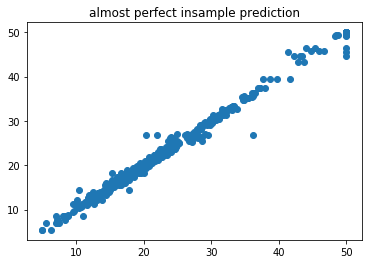

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x = y,y = np.array(pred))
plt.gca().set_title('almost perfect insample prediction')


#### Hold-out validation:

In [20]:
idx = [i for i in range(len(y))]
np.random.seed(1028)
np.random.shuffle(idx)
val_ratio = 0.2
val_num = int(len(y)*val_ratio)

print("We will be using {} validation examples".format(val_num))

X_train,X_valid = X[val_num:], X[:val_num]
y_train,y_valid = y[val_num:], y[:val_num]

We will be using 101 validation examples


In [21]:
model = CART_regressor(least_children_num = 5,verbose=False)
model.fit(X_train,y_train)

In [22]:
# validation
pred = model.predict(X_valid)

In [23]:
np.mean((np.array(pred) -  y_valid)**2)

14.294261551155115

Text(0.5,1,"Not perfect, but it's working")

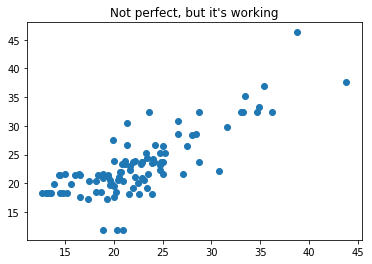

In [24]:
plt.scatter(x = y_valid,y = np.array(pred))
plt.gca().set_title('Not perfect, but it\'s working')


### Since we build the CART for gradient boosting, we will not perform pruning here